In [1]:
import mitsuba as mi

for variant in (['cuda_ad_rgb', 'llvm_ad_rgb', 'scalar_rgb']):
    try:
        mi.set_variant(variant)
        print(f'Using {variant.split('_')[0].upper()} backend')
        break
    except ImportError:
        pass

from mitsuba import ScalarTransform4f as ST
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

Using CUDA backend


## Mesh reading, image taking

In [2]:
obj = 'Weisshai_Great_White_Shark'
obj_path = Path(f'../data/raw_objects/{obj}/').absolute()

def load_and_normalize_mesh(obj_path: Path) -> mi.Mesh:
    mesh: mi.Mesh = mi.load_dict({
        'type': 'obj',
        'filename': (obj_path / 'meshes/model.obj').as_posix(),
    })

    bbox = mesh.bbox()  # Used for re-centering and scaling to -1:1 bounding box

    mesh: mi.Mesh = mi.load_dict({
        'type': 'obj',
        'filename': (obj_path / 'meshes/model.obj').as_posix(),
        'to_world': ST().scale(1 / max(abs(bbox.max - bbox.min) / 2)).translate(-(bbox.max + bbox.min) / 2),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'bitmap',
                'filename': (obj_path / 'materials/textures/texture.png').as_posix(),
                'wrap_mode': 'clamp',
                'filter_type': 'bilinear',
            }
        },
    })

    return mesh


mesh = load_and_normalize_mesh(obj_path)
mesh.bbox()

BoundingBox3f[
  min = [-0.860059, -1, -0.447512],
  max = [0.860059, 1, 0.447512]
]

In [3]:
sensor = mi.load_dict({
    'type': 'perspective',
    'fov': 40,
    'fov_axis': 'x',
    'to_world': ST().look_at(
        origin=ST().rotate([0, 0, 1], 20).rotate([0, 1, 0], 10) @ mi.ScalarPoint3f([0, 0, 4]),
        target=[0, 0, 0],
        up=[0, 0, 1],
    )
})

def sensor_c2w(sensor: mi.Sensor):
    transf = np.array(sensor.world_transform().matrix, dtype=np.float32)[:,:,0]
    # after experimentation, this -1 multiplier is required to get correct ray directions
    transf[:3, :3] *= -1
    return transf

print(sensor_c2w(sensor))

[[-0.3420201   0.92541665  0.16317594  0.6527037 ]
 [ 0.9396926   0.33682406  0.05939118  0.23756468]
 [-0.         -0.17364821  0.98480785  3.939231  ]
 [ 0.          0.          0.          1.        ]]


1.0
(64, 400, 400, 4)


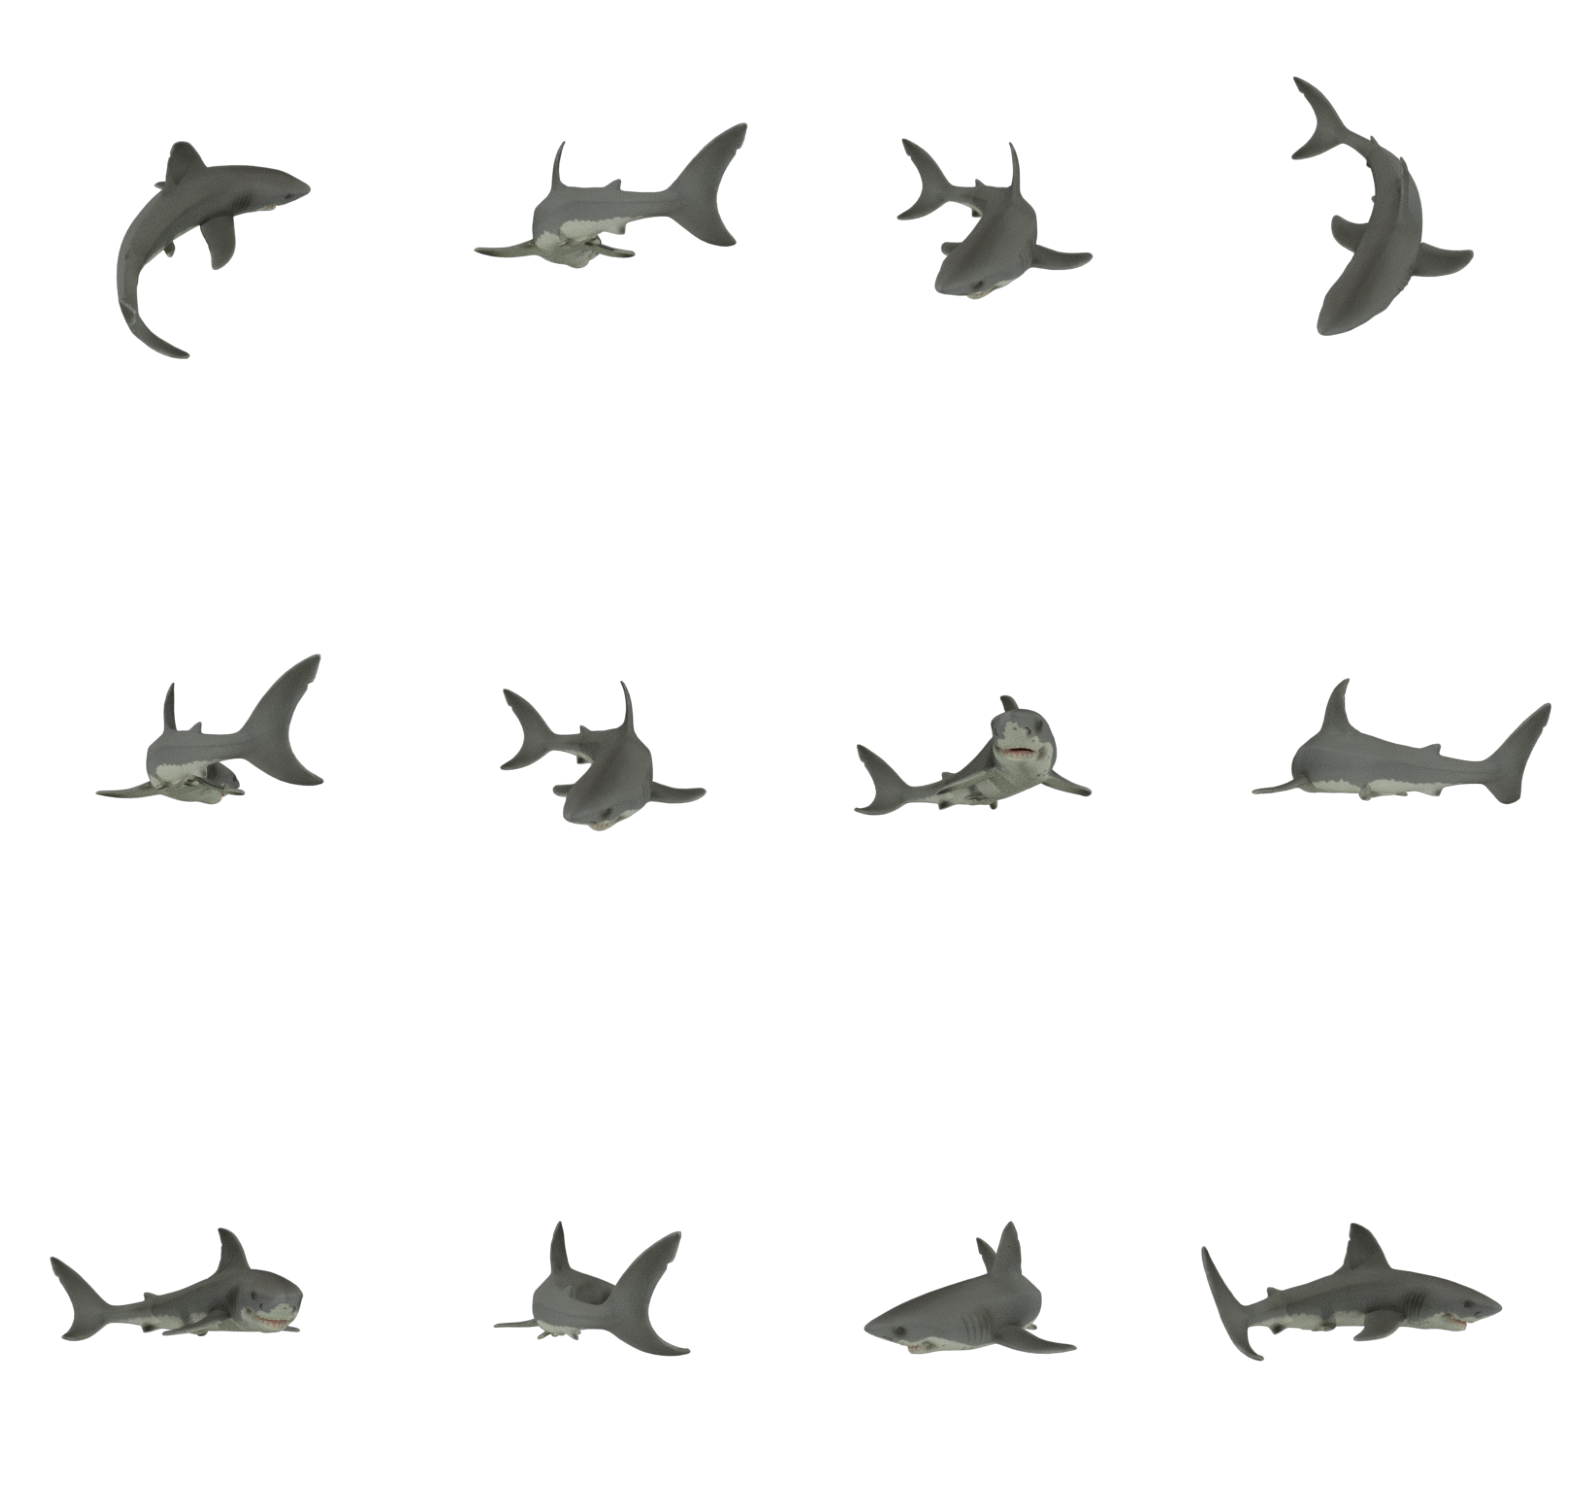

In [ ]:
scene_dict: dict = {
    'type': 'scene',
    'integrator': {'type': 'path', 'max_depth': 4},
    'obj': mesh,
}

for i, pos in enumerate([
    [0.0, 1.0, 0.0],
    [0.0, -1.0, 0.0],
    [1.0, 0, 0.0],
    [-1.0, 0, 0.0],
    [0.0, 0, 1.0],
    [0.0, 0, -1.0],
]):
    scene_dict[f'light{i}'] = {
        'type': 'directional',
        'direction': pos,
        'irradiance': {
            'type': 'rgb',
            'value': 1,
        }
    }

scene: mi.Scene = mi.load_dict(scene_dict)


def create_batch_sensor(n: int, radius: float, size: int = 800, fov_x: float = 40, deterministic=False) -> mi.Sensor:
    focal = (size / 2) / np.tan(np.deg2rad(fov_x) / 2)

    i = np.arange(0, n, dtype=float) + 0.5
    thetas = np.rad2deg(np.pi * i * (1 + np.sqrt(5))) % 360
    phis = np.rad2deg(np.arccos(1 - 2 * i / n))

    if not deterministic:
        # Small modulation to angles
        thetas += np.random.randn(thetas.shape[0]).clip(-1, 1) * (thetas[1:] - thetas[:-1]).mean()
        phis += np.random.randn(phis.shape[0]).clip(-1, 1) * (phis[1:] - phis[:-1]).mean()

    sensors: list[mi.Sensor] = [mi.load_dict({
        'type': 'perspective',
        'fov': fov_x,
        'fov_axis': 'x',
        'to_world': ST().look_at(
            # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
            origin=[
                radius * np.cos(phi) * np.sin(theta),
                radius * np.sin(phi),
                radius * np.cos(phi) * np.cos(theta),
            ],
            target=[0, 0, 0],
            up=[0, 0, 1],
        )
    }) for theta, phi in zip(thetas, phis)]


    extrinsics: np.ndarray = np.stack([sensor_c2w(s) for s in sensors], axis=0)

    batch_sensor = {
        'type': 'batch',
        'sampler': {
            'type': 'ldsampler',
            'sample_count': 64,
        },
        'film': {
            'type': 'hdrfilm',
            'width': size * len(sensors),
            'height': size,
            'pixel_format': 'rgba',
            'filter': {
                'type': 'tent'
            }
        },
    }
    batch_sensor.update({f's{i}': s for i, s in enumerate(sensors)})

    return mi.load_dict(batch_sensor), extrinsics, focal.astype(np.float32)

sensor_count = 64
radius = 4

sensor, extrinsics, focal = create_batch_sensor(sensor_count, radius, size=400)

render = np.asarray(mi.render(scene, sensor=sensor), dtype=np.float32).clip(0,1)
# This is complicated because srgb conversion is done here too (saving to disk would do this too)
# If saving to disk is the goal, this shouldn't be done as the conversion would happen again
images = np.asarray(mi.Bitmap(render).convert(srgb_gamma=True, component_format=mi.Struct.Type.Float32))

images = images.reshape(400, -1, 400, 4).transpose(1, 0, 2, 3)
print(images.shape)
fig = plt.figure(figsize=(20, 28))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(12):
    ax = fig.add_subplot(4, 4, i + 1).imshow(images[i])
    plt.axis("off")

In [9]:
np.savez_compressed(obj, images=images, c2ws=extrinsics, focal=focal)

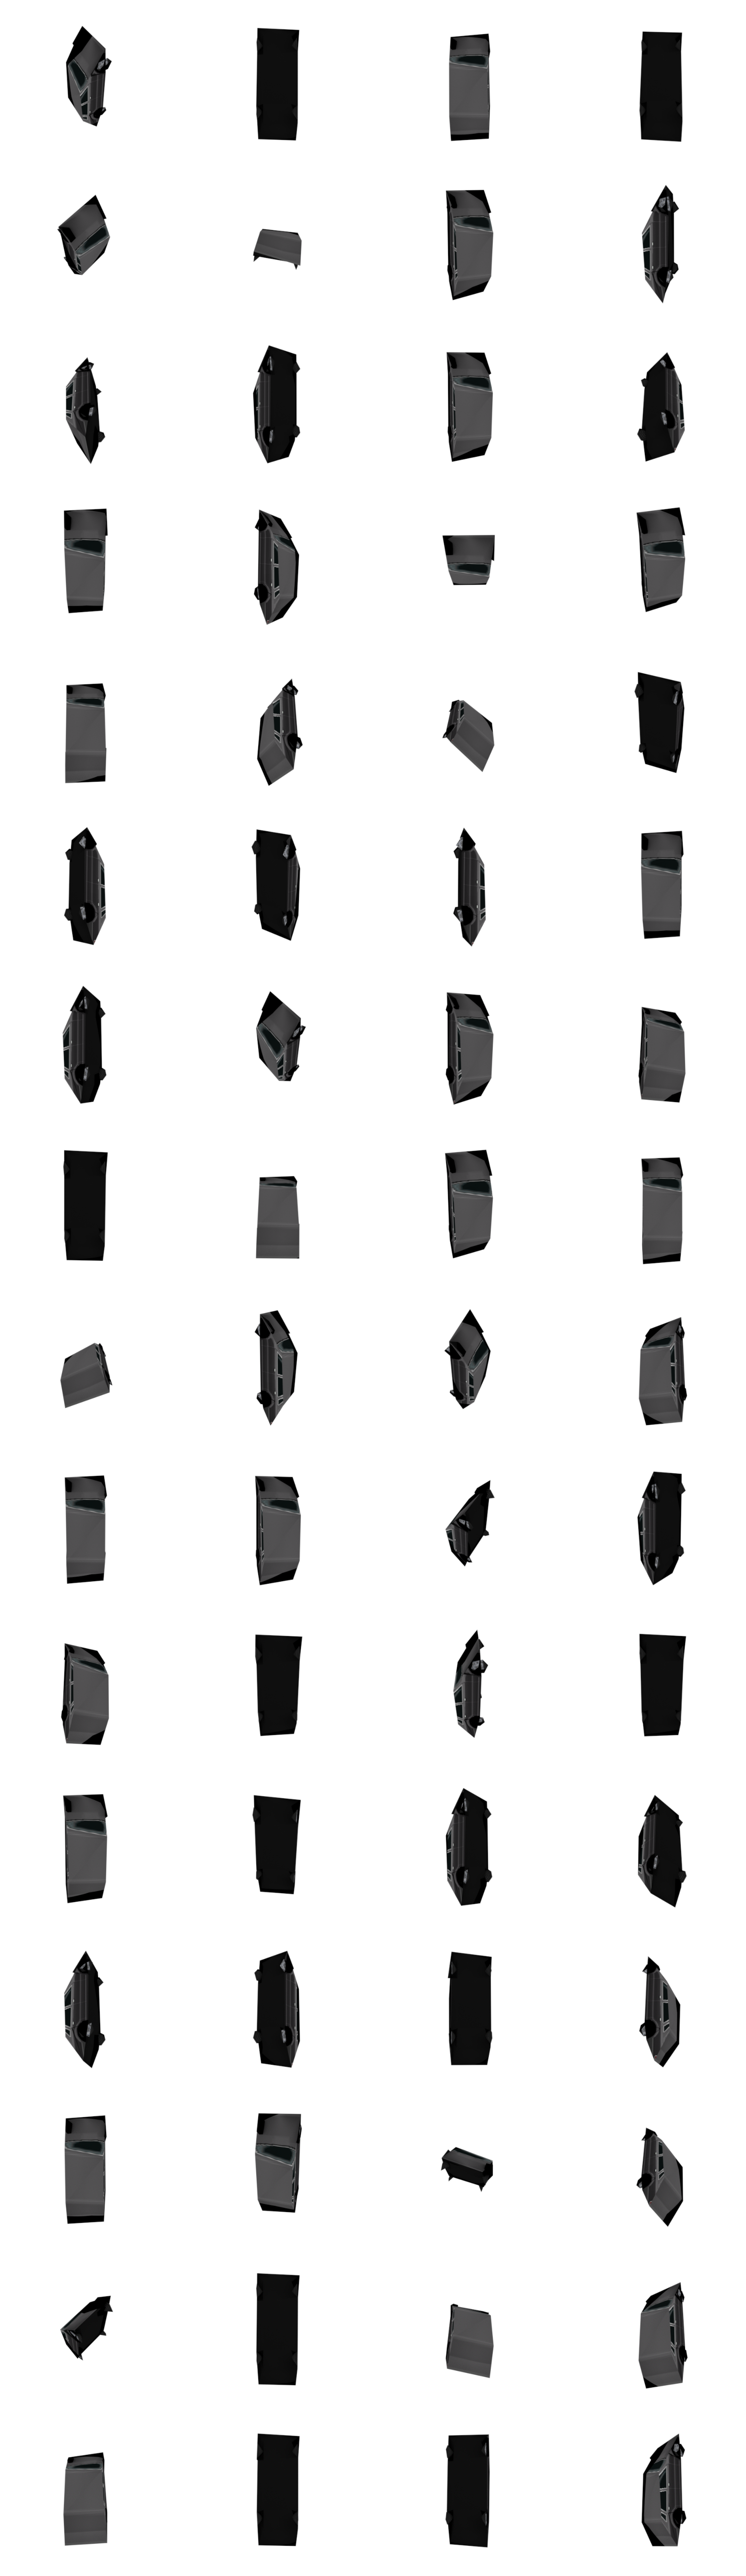

In [8]:
fig = plt.figure(figsize=(5 * 4, 5 * images.shape[0] // 4 + 4))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(images.shape[0]):
    ax = fig.add_subplot(images.shape[0] // 4 + 4, 4, i + 1).imshow(images[i])
    plt.axis("off")